In [7]:
import pandas as pd
import os, sys
from collections import Counter
import geopandas as gpd
import pylab as pl
from fiona.crs import from_epsg
import shapely 
import seaborn as sns
from shapely.geometry import Point
import pyproj

sns.set_style("white")
sns.set_palette('coolwarm')
sns.set_context('talk')

% pylab inline

Populating the interactive namespace from numpy and matplotlib


# Turn RDD output into orderly dataframe

In [8]:
df = pd.read_csv('/Users/shay/CUSP/BDM/results.csv', index_col = 0)
df.columns = ['Date_Hour', 'Results']

df['Results'] = df['Results'].apply(lambda x: eval(x))

final = pd.DataFrame()
for row in range(len(df)):
    tempdf = pd.DataFrame.from_dict(df.Results[row], orient = 'index')
    tempdf.reset_index(inplace = True)
    tempdf.columns = ['Station', 'Taxi_Rides']
    tempdf['Date_Hour'] = df.Date_Hour[row]
    final = final.append(tempdf)

final.reset_index(inplace = True, drop=True)
final['Date'] = final['Date_Hour'].apply(lambda x: x.split(', ')[0][1:])
final['Hour'] = final['Date_Hour'].apply(lambda x: x.split(', ')[1][:-1])
final['Station'] = final['Station'].convert_objects(convert_numeric = True)
final['Station'] = final['Station'].apply(lambda x: int(x))
final.drop('Date_Hour', axis = 1, inplace = True)

final.to_csv('finaldf.csv')

/Users/shay/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [9]:
len(final)

69710

# Merge with subway delay data

In [10]:
df95 = pd.read_csv('/Users/shay/CUSP/BDM/subway_taxi_project/merged_4_30.csv')

final['keycol'] = final.Station.map(lambda x: str(x) + '_') + \
                final.Date.map(lambda x: str(x) + '_') + \
                final.Hour.map(lambda x: str(x))

merged = final.merge(df95, left_on = 'keycol', right_on = 'keycol', how = 'right')

merged.set_index('keycol', inplace = True)

# Read in subway shapefile, create 300 foot buffer

In [11]:
merged = pd.read_csv('/Users/shay/CUSP/BDM/subway_taxi_project/merged_4_30.csv')

In [12]:
filepath = '/Users/shay/CUSP/BDM/subway_taxi_project/data/subwaystations/subwaystations.shp'
subwayst = gpd.read_file(filepath)

In [13]:
subwayst.crs = from_epsg(4326)
subwayst = subwayst.to_crs(epsg = 2263)

In [14]:
subwayst['buffer'] = subwayst.geometry.apply(lambda x: x.buffer(300))
subwayst.set_geometry('buffer', crs = 2263, inplace = True)

# Attach shapes to DataFrame

In [15]:
subwayst.objectid = subwayst.objectid.map(lambda x: int(x))

In [16]:
subwaytaxi = subwayst.merge(merged, left_on = 'objectid', right_on = 'Station', how = 'right')

# Some Visualizations

In [17]:
viz_df = subwaytaxi.groupby('Station').mean()
viz_df = viz_df.merge(subwayst)

In [18]:
viz_df.drop(['geometry', 'notes', 'url'], axis = 1, inplace = True)

In [19]:
viz_df = gpd.GeoDataFrame(viz_df, geometry = 'buffer')

In [20]:
viz_df = viz_df[viz_df.Taxi_Rides > 5]

In [21]:
viz_df.Taxi_Rides.describe()

count     48.000000
mean      31.514475
std       31.850583
min        5.046683
25%       13.500766
50%       25.408823
75%       37.788293
max      213.062053
Name: Taxi_Rides, dtype: float64

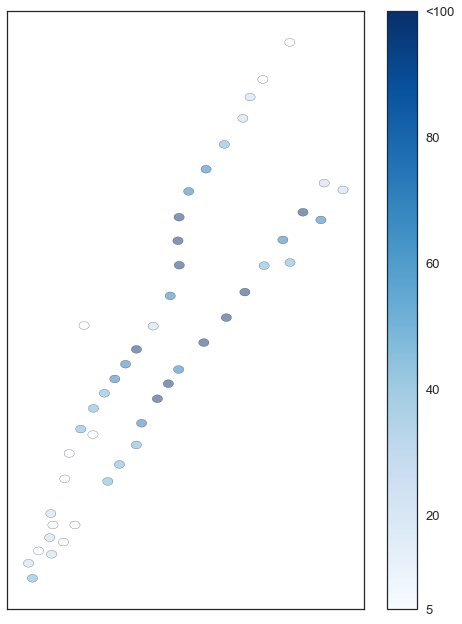

In [22]:
fig, ax = pl.subplots(figsize = (8, 11))
pl.tick_params(which = 'both',
              labelbottom = 'off',
              labelleft = 'off')
viz_df.plot('Taxi_Rides', ax = ax, cmap = cm.Blues, scheme = 'quantiles', linewidth = .2)
m = cm.ScalarMappable(cmap=cm.Blues)

m.set_array(np.linspace(5, 100, 200))
pl.tick_params(which = 'both',
              labelbottom = 'off',
              labelleft = 'off')

cbar = fig.colorbar(m)
cbar.set_ticks([5, 20, 40, 60, 80, 100])
cbar.set_ticklabels([5, 20, 40, 60, 80, '<100'])
pl.savefig('avgridership.png')

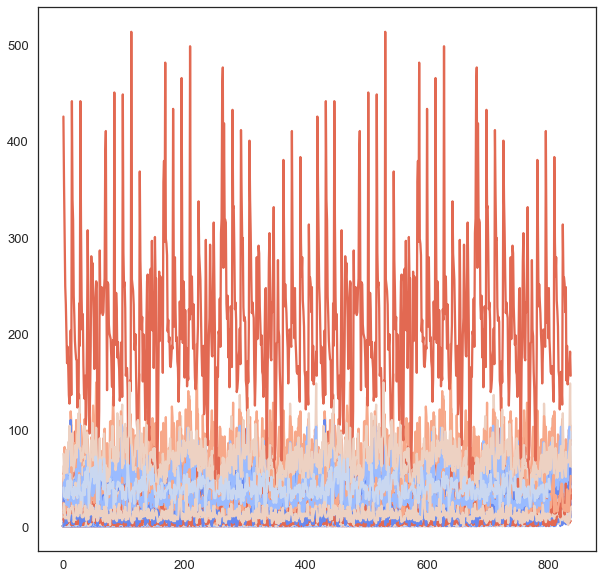

In [23]:
merged.sort_values(['Date', 'Hour'], inplace = True)
fig = pl.figure(figsize(10, 10))
for station in subwaytaxi.objectid.unique():
    filterd = subwaytaxi[subwaytaxi.objectid == station]
    pl.plot(range(len(filterd)), filterd.Taxi_Rides, label = filterd.name.iloc[0])

In [24]:
avgsdf = subwaytaxi.groupby('Station').mean().sort_values('Taxi_Rides', ascending = False)

In [25]:
subwaytaxi['nameline'] = subwaytaxi['name'] + subwaytaxi['line']

In [26]:
withdelays = subwaytaxi[subwaytaxi.delay > 0].groupby('nameline')[['Taxi_Rides', 'nameline']].mean().sort_values('Taxi_Rides', ascending = False)

In [27]:
nodelays = subwaytaxi[subwaytaxi.delay == 0].groupby('nameline')[['Taxi_Rides', 'nameline']].mean().sort_values('Taxi_Rides', ascending = False)

In [28]:
comparison = withdelays.merge(nodelays, left_index = True, right_index = True, suffixes = ('_with', '_without'))

In [29]:
comparison[comparison.Taxi_Rides_with > comparison.Taxi_Rides_without]

,Taxi_Rides_with,Taxi_Rides_without
nameline,,
59th St - Columbus Circle1-2,75.653595,73.605263
51st St4-6-6 Express,55.548387,50.206780
Lexington Ave - 59th St4-5-6-6 Express,53.401639,49.528620
86th StQ,40.164179,39.626866
23rd St1-2,37.428571,35.478469
Union Sq - 14th St4-5-6-6 Express,36.863636,33.993958
79th St1-2,33.405660,33.294686
50th St1-2,33.078947,31.266376
96th St1-2-3,29.246377,28.597865


In [30]:
comparison[comparison.Taxi_Rides_with < comparison.Taxi_Rides_without]

,Taxi_Rides_with,Taxi_Rides_without
nameline,,
34th St - Penn Station1-2-3,206.011494,218.069388
86th St4-5-6-6 Express,64.469697,74.216028
Grand Central - 42nd St4-5-6-6 Express,55.023529,58.742515
72nd St1-2-3,52.109091,52.566929
28th St4-6-6 Express,46.805556,49.701681
66th St - Lincoln Ctr1-2,49.061321,49.611650
23rd St4-6-6 Express,43.844828,48.269388
33rd St4-6-6 Express,37.148810,47.972112
28th St1-2,36.812183,37.441441


In [31]:
subwaytaxi['delayed'] = subwaytaxi.delay.apply(lambda x: 1 if x > 0 else 0)

In [32]:
vizdf2 = subwayst.merge(subwaytaxi.groupby(['nameline', 'delayed']).mean(), how = 'right')

In [33]:
comparison['percchange'] = ((comparison['Taxi_Rides_with'] - comparison['Taxi_Rides_without']) / \
                            comparison['Taxi_Rides_without'] ) * 100
comparison.fillna(0, inplace = True)

In [34]:
vizdf3 = subwaytaxi.groupby('nameline').mean().merge(comparison, right_index = True, left_index = True)

In [35]:
vizdf3 = vizdf3.merge(subwayst, how='left')

In [36]:
vizdf3 = vizdf3[vizdf3.Taxi_Rides > 5]

In [37]:
vizdf3[vizdf3.percchange == vizdf3.percchange.min()]

,objectid,delay,Station,Taxi_Rides,Date,Hour,new_station,delayed,Taxi_Rides_with,Taxi_Rides_without,percchange,geometry,line,name,notes,url,buffer
10,32.0,0.835322,32.0,43.632458,15.505967,13.484487,632.0,0.400955,37.14881,47.972112,-22.561654,POINT (989216.5458293119 211094.5768763313),4-6-6 Express,33rd St,"4 nights, 6-all times, 6 Express-weekdays AM s...",http://web.mta.info/nyct/service/,"POLYGON ((989516.5458293119 211094.5768763313,..."


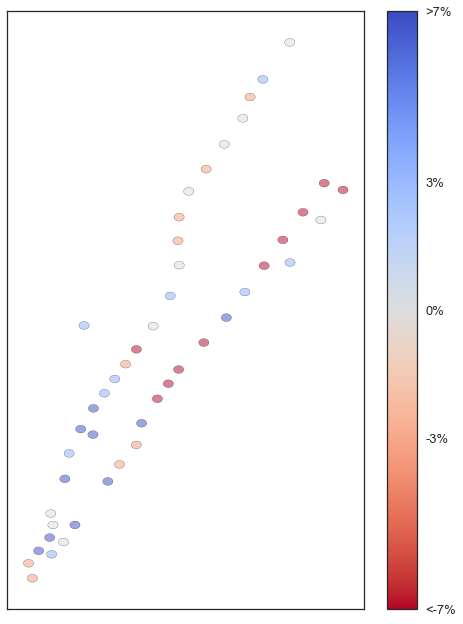

In [38]:
fig, ax = pl.subplots(figsize = (8, 11))

vizdf3 = gpd.GeoDataFrame(vizdf3, geometry = 'buffer')

vmax = 7
vmin = -7
vizdf3.plot('percchange', cmap = cm.coolwarm_r, scheme = 'quantiles', linewidth = .2,
           ax = ax)

m = cm.ScalarMappable(cmap=cm.coolwarm_r)
m.set_array(np.linspace(vmin, vmax, 200))
pl.tick_params(which = 'both',
              labelbottom = 'off',
              labelleft = 'off')

cbar = fig.colorbar(m)
cbar.set_ticks([vmin, -3, 0, 3, vmax])
cbar.set_ticklabels(['<-7%', '-3%', '0%', '3%', '>7%'])
pl.savefig('percentdiffnotime.png')

In [39]:
morningcommute = subwaytaxi[subwaytaxi.Hour < 11]

In [40]:
eveningcommute = subwaytaxi[subwaytaxi.Hour > 16][subwaytaxi.Hour < 20]

/Users/shay/anaconda2/lib/python2.7/site-packages/geopandas/geodataframe.py:376: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)


In [41]:
offhours = subwaytaxi[subwaytaxi.Hour > 11][subwaytaxi.Hour < 18]

In [42]:
from scipy.stats import ttest_ind

In [43]:
stations = morningcommute.Station.unique()
mornres = []
everes = []
offres = []
mornstat = []
evestat = []
offstat = []
mornavgdel = []
mornavgnodel = []
eveavgdel = []
eveavgnodel = []
offavgdel = []
offavgnodel = []

for station in stations: 
    a = morningcommute[morningcommute.Station == station][morningcommute.delayed == 1].Taxi_Rides
    b = morningcommute[morningcommute.Station == station][morningcommute.delayed == 0].Taxi_Rides
    c = eveningcommute[eveningcommute.Station == station][eveningcommute.delayed == 1].Taxi_Rides
    d = eveningcommute[eveningcommute.Station == station][eveningcommute.delayed == 0].Taxi_Rides
    e = offhours[offhours.Station == station][offhours.delayed == 1].Taxi_Rides
    f = offhours[offhours.Station == station][offhours.delayed == 0].Taxi_Rides
    morntest = ttest_ind(a, b, equal_var=0)
    evetest = ttest_ind(c, d, equal_var = 0)
    offtest = ttest_ind(e, f, equal_var = 0)
    mornres.append(morntest.pvalue)
    everes.append(evetest.pvalue)
    offres.append(offtest.pvalue)
    mornstat.append(morntest.statistic)
    evestat.append(evetest.statistic)
    offstat.append(offtest.statistic)
    mornavgdel.append(a.mean())
    mornavgnodel.append(b.mean())
    eveavgdel.append(c.mean())
    eveavgnodel.append(d.mean())
    offavgdel.append(e.mean())
    offavgnodel.append(f.mean())
    

In [44]:
mornres = np.array(mornres)
everes = np.array(everes)
mornstat = np.array(mornstat)
evestat = np.array(evestat)

In [45]:
resdf = pd.DataFrame({'station': stations,
                      'mornres': mornres,
                      'mornstat': mornstat,
                      'mornavgdel': mornavgdel,
                      'mornavgnodel':mornavgnodel,
                      'everes': everes,
                      'evestat': evestat,
                      'eveavgdel': eveavgdel,
                      'eveavgnodel':eveavgnodel, 
                       'offres': offres,
                      'offstat': offstat,
                      'offavgdel': offavgdel,
                      'offavgnodel':offavgnodel})

In [46]:
results = resdf.merge(subwaytaxi, left_on = 'station', right_on='objectid')

In [47]:
resdf.dropna(inplace = True)

In [48]:
results = resdf.merge(subwaytaxi.groupby('nameline', as_index = False).mean()[['objectid', 'nameline', 'Taxi_Rides']], 
                      left_on = 'station', right_on = 'objectid', how = 'left')

In [49]:
results['percchangemorn'] = (results['mornavgdel'] - results['mornavgnodel']) / results['mornavgnodel']
results['percchangeeve'] = (results['eveavgdel'] - results['eveavgnodel']) / results['eveavgnodel']
results['percchangeoff'] = (results['offavgdel'] - results['offavgnodel']) / results['offavgnodel']

In [50]:
mergedttest = comparison.merge(results, right_on = 'nameline', left_index = True )

In [51]:
mergedttest[mergedttest.everes < 0.025][results.evestat > 0].head()

/Users/shay/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,Taxi_Rides_with,Taxi_Rides_without,percchange,eveavgdel,eveavgnodel,everes,evestat,mornavgdel,mornavgnodel,mornres,...,offavgnodel,offres,offstat,station,objectid,nameline,Taxi_Rides,percchangemorn,percchangeeve,percchangeoff
49,206.011494,218.069388,-5.529384,229.758621,182.934426,0.000868,3.466840,193.489362,293.602740,6.924045e-12,...,177.907563,3.193820e-04,3.647324,358,358.0,34th St - Penn Station1-2-3,213.062053,-0.340982,0.255962,0.094785
18,37.428571,35.478469,5.496580,45.617647,39.232143,0.000417,3.613231,29.694915,34.344262,9.596540e-05,...,33.533981,2.205314e-03,3.094112,96,96.0,23rd St1-2,36.455847,-0.135375,0.162762,0.088255
73,31.288043,26.510638,18.020710,40.350000,35.220000,0.000577,3.512319,16.000000,20.815789,6.380602e-06,...,28.018182,2.961970e-06,4.793756,467,467.0,Spring St4-6-6 Express,28.608592,-0.231353,0.145656,0.161491
3,8.839552,6.514286,35.694881,11.590164,8.965517,0.000040,4.223359,5.458333,3.378378,1.130341e-05,...,7.178082,5.413578e-09,5.994126,29,29.0,Brooklyn Bridge - City Hall4-5-6-6 Express,8.041667,0.615667,0.292749,0.359278
39,4.389535,3.483568,26.006864,4.222222,2.954545,0.001643,3.233128,4.627907,3.900000,4.626677e-02,...,3.274510,1.346195e-03,3.243296,172,172.0,137th St - City College1,3.888312,0.186643,0.429060,0.371828


In [52]:
mergedttest[mergedttest.mornres < 0.025][results.mornstat > 0]

/Users/shay/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,Taxi_Rides_with,Taxi_Rides_without,percchange,eveavgdel,eveavgnodel,everes,evestat,mornavgdel,mornavgnodel,mornres,...,offavgnodel,offres,offstat,station,objectid,nameline,Taxi_Rides,percchangemorn,percchangeeve,percchangeoff
3,8.839552,6.514286,35.694881,11.590164,8.965517,0.000040,4.223359,5.458333,3.378378,0.000011,...,7.178082,5.413578e-09,5.994126,29,29.0,Brooklyn Bridge - City Hall4-5-6-6 Express,8.041667,0.615667,0.292749,0.359278
67,3.616667,3.277778,10.338983,3.195122,4.127660,0.007554,-2.707350,4.555556,3.157143,0.000043,...,3.428571,5.310134e-01,0.627158,450,450.0,110th St4-6-6 Express,3.431818,0.442936,-0.225924,0.048309


In [53]:
mergedttest[mergedttest.everes < 0.025][results.evestat < 0].head()

/Users/shay/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,Taxi_Rides_with,Taxi_Rides_without,percchange,eveavgdel,eveavgnodel,everes,evestat,mornavgdel,mornavgnodel,mornres,...,offavgnodel,offres,offstat,station,objectid,nameline,Taxi_Rides,percchangemorn,percchangeeve,percchangeoff
68,64.469697,74.216028,-13.132380,74.612903,84.949153,0.002491,-3.104387,52.551724,66.582418,2.086506e-06,...,76.776978,9.697115e-08,-5.649432,451,451.0,86th St4-5-6-6 Express,71.145585,-0.210727,-0.121676,-0.131472
12,55.548387,50.206780,10.639215,67.666667,77.238095,0.017492,-2.418809,37.900000,40.088889,3.227068e-01,...,46.834483,2.177345e-04,-3.798311,85,85.0,51st St4-6-6 Express,51.787589,-0.054601,-0.123921,-0.112986
45,46.805556,49.701681,-5.827016,58.153846,68.360000,0.001832,-3.174977,29.584906,40.880597,9.781863e-09,...,49.079365,3.972699e-13,-7.810286,200,200.0,28th St4-6-6 Express,48.454545,-0.276309,-0.149300,-0.208010
10,53.401639,49.528620,7.819761,71.896552,82.524590,0.000459,-3.632796,17.407407,20.612903,1.749146e-02,...,60.366197,1.102810e-01,1.607335,49,49.0,Lexington Ave - 59th St4-5-6-6 Express,50.656325,-0.155509,-0.128786,0.051477
16,43.844828,48.269388,-9.166390,57.956522,66.409091,0.001441,-3.238211,29.142857,47.025641,1.053735e-14,...,45.626016,2.386013e-05,-4.324836,92,92.0,23rd St4-6-6 Express,46.431981,-0.380277,-0.127280,-0.122538


In [54]:
mergedttest[mergedttest.mornres < 0.025][results.mornstat < 0].head()

/Users/shay/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,Taxi_Rides_with,Taxi_Rides_without,percchange,eveavgdel,eveavgnodel,everes,evestat,mornavgdel,mornavgnodel,mornres,...,offavgnodel,offres,offstat,station,objectid,nameline,Taxi_Rides,percchangemorn,percchangeeve,percchangeoff
49,206.011494,218.069388,-5.529384,229.758621,182.934426,0.000868,3.466840,193.489362,293.602740,6.924045e-12,...,177.907563,3.193820e-04,3.647324,358,358.0,34th St - Penn Station1-2-3,213.062053,-0.340982,0.255962,0.094785
68,64.469697,74.216028,-13.132380,74.612903,84.949153,0.002491,-3.104387,52.551724,66.582418,2.086506e-06,...,76.776978,9.697115e-08,-5.649432,451,451.0,86th St4-5-6-6 Express,71.145585,-0.210727,-0.121676,-0.131472
4,55.023529,58.742515,-6.330995,57.352941,56.849315,0.893485,0.134670,46.812500,71.653846,4.679418e-08,...,47.878205,4.151981e-03,2.990613,31,31.0,Grand Central - 42nd St4-5-6-6 Express,57.988067,-0.346685,0.008859,0.193132
45,46.805556,49.701681,-5.827016,58.153846,68.360000,0.001832,-3.174977,29.584906,40.880597,9.781863e-09,...,49.079365,3.972699e-13,-7.810286,200,200.0,28th St4-6-6 Express,48.454545,-0.276309,-0.149300,-0.208010
14,49.061321,49.611650,-1.109275,63.321429,60.786885,0.252571,1.151614,32.233333,35.300000,2.322050e-02,...,53.390000,1.989848e-02,2.340565,88,88.0,66th St - Lincoln Ctr1-2,49.332536,-0.086874,0.041696,0.058016


In [55]:
# create categorical
# 1 = significant (and higher)
# 2 = significant (and lower)
# 3 else 0

In [56]:
mornsig = np.zeros(len(mergedttest))
evesig = np.zeros(len(mergedttest))
sigeve = mergedttest[mergedttest.everes < 0.025][results.evestat < 0]
sigmorn = mergedttest[mergedttest.mornres < 0.025][results.mornstat < 0]

/Users/shay/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/Users/shay/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [57]:
mergedttest[mergedttest['mornres'] < 0.025][results['mornstat'] < 0]

/Users/shay/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,Taxi_Rides_with,Taxi_Rides_without,percchange,eveavgdel,eveavgnodel,everes,evestat,mornavgdel,mornavgnodel,mornres,...,offavgnodel,offres,offstat,station,objectid,nameline,Taxi_Rides,percchangemorn,percchangeeve,percchangeoff
49,206.011494,218.069388,-5.529384,229.758621,182.934426,0.000868,3.466840,193.489362,293.602740,6.924045e-12,...,177.907563,3.193820e-04,3.647324,358,358.0,34th St - Penn Station1-2-3,213.062053,-0.340982,0.255962,0.094785
68,64.469697,74.216028,-13.132380,74.612903,84.949153,0.002491,-3.104387,52.551724,66.582418,2.086506e-06,...,76.776978,9.697115e-08,-5.649432,451,451.0,86th St4-5-6-6 Express,71.145585,-0.210727,-0.121676,-0.131472
4,55.023529,58.742515,-6.330995,57.352941,56.849315,0.893485,0.134670,46.812500,71.653846,4.679418e-08,...,47.878205,4.151981e-03,2.990613,31,31.0,Grand Central - 42nd St4-5-6-6 Express,57.988067,-0.346685,0.008859,0.193132
45,46.805556,49.701681,-5.827016,58.153846,68.360000,0.001832,-3.174977,29.584906,40.880597,9.781863e-09,...,49.079365,3.972699e-13,-7.810286,200,200.0,28th St4-6-6 Express,48.454545,-0.276309,-0.149300,-0.208010
14,49.061321,49.611650,-1.109275,63.321429,60.786885,0.252571,1.151614,32.233333,35.300000,2.322050e-02,...,53.390000,1.989848e-02,2.340565,88,88.0,66th St - Lincoln Ctr1-2,49.332536,-0.086874,0.041696,0.058016
10,53.401639,49.528620,7.819761,71.896552,82.524590,0.000459,-3.632796,17.407407,20.612903,1.749146e-02,...,60.366197,1.102810e-01,1.607335,49,49.0,Lexington Ave - 59th St4-5-6-6 Express,50.656325,-0.155509,-0.128786,0.051477
16,43.844828,48.269388,-9.166390,57.956522,66.409091,0.001441,-3.238211,29.142857,47.025641,1.053735e-14,...,45.626016,2.386013e-05,-4.324836,92,92.0,23rd St4-6-6 Express,46.431981,-0.380277,-0.127280,-0.122538
5,37.148810,47.972112,-22.561654,44.450000,51.300000,0.006857,-2.740090,27.809524,46.679487,1.212935e-12,...,47.682540,5.187063e-17,-9.253298,32,32.0,33rd St4-6-6 Express,43.632458,-0.404245,-0.133528,-0.308700
7,29.440559,35.804348,-17.773787,34.000000,41.945455,0.000052,-4.164828,22.485714,30.670588,6.995866e-11,...,38.029412,3.319453e-10,-6.668549,34,34.0,77th St4-6-6 Express,33.632458,-0.266864,-0.189423,-0.217113
18,37.428571,35.478469,5.496580,45.617647,39.232143,0.000417,3.613231,29.694915,34.344262,9.596540e-05,...,33.533981,2.205314e-03,3.094112,96,96.0,23rd St1-2,36.455847,-0.135375,0.162762,0.088255


In [115]:
mergedttest['mornsign'] = [1 if (mergedttest['mornres'][x] < 0.025) & (results['mornstat'][x] > 0) else 0
                           for x in mergedttest.index]
mergedttest['evesign'] = [1 if (mergedttest['everes'][x] < 0.025) & (results['evestat'][x] > 0) else 0
                           for x in mergedttest.index]
mergedttest['offsign'] = [1 if (mergedttest['offres'][x] < 0.025) & (results['offstat'][x] > 0) else 0
                           for x in mergedttest.index]

In [119]:
mergedttest[mergedttest.offsign == 1]

,Taxi_Rides_with,Taxi_Rides_without,percchange,eveavgdel,eveavgnodel,everes,evestat,mornavgdel,mornavgnodel,mornres,...,station,objectid,nameline,Taxi_Rides,percchangemorn,percchangeeve,percchangeoff,mornsign,evesign,offsign
49,206.011494,218.069388,-5.529384,229.758621,182.934426,0.000868,3.466840,193.489362,293.602740,6.924045e-12,...,358,358.0,34th St - Penn Station1-2-3,213.062053,-0.340982,0.255962,0.094785,0,1,1
4,55.023529,58.742515,-6.330995,57.352941,56.849315,0.893485,0.134670,46.812500,71.653846,4.679418e-08,...,31,31.0,Grand Central - 42nd St4-5-6-6 Express,57.988067,-0.346685,0.008859,0.193132,0,0,1
14,49.061321,49.611650,-1.109275,63.321429,60.786885,0.252571,1.151614,32.233333,35.300000,2.322050e-02,...,88,88.0,66th St - Lincoln Ctr1-2,49.332536,-0.086874,0.041696,0.058016,0,0,1
77,40.164179,39.626866,1.355932,47.000000,47.259259,0.923077,-0.098519,33.714286,33.010204,7.129170e-01,...,642,642.0,86th StQ,39.716418,0.021329,-0.005486,0.103960,0,0,1
18,37.428571,35.478469,5.496580,45.617647,39.232143,0.000417,3.613231,29.694915,34.344262,9.596540e-05,...,96,96.0,23rd St1-2,36.455847,-0.135375,0.162762,0.088255,0,1,1
76,29.014925,27.247761,6.485539,32.166667,30.000000,0.390799,0.889209,29.785714,28.102041,4.072822e-01,...,641,641.0,72nd StQ,27.542289,0.059913,0.072222,0.165169,0,0,1
73,31.288043,26.510638,18.020710,40.350000,35.220000,0.000577,3.512319,16.000000,20.815789,6.380602e-06,...,467,467.0,Spring St4-6-6 Express,28.608592,-0.231353,0.145656,0.161491,0,1,1
46,25.795122,24.677570,4.528614,31.512821,31.333333,0.896156,0.130713,18.622642,20.925373,1.987307e-02,...,203,203.0,18th St1-2,25.224344,-0.110045,0.005728,0.118737,0,0,1
65,25.120690,23.126531,8.622820,29.250000,28.787879,0.802265,0.251210,19.260870,22.027027,9.398272e-04,...,439,439.0,14th St1-2-3,23.954654,-0.125580,0.016053,0.199678,0,0,1
57,19.605634,20.075235,-2.339207,28.555556,25.094595,0.199066,1.332621,12.250000,15.895833,2.914463e-02,...,418,418.0,South Ferry1,19.989744,-0.229358,0.137917,0.182398,0,0,1


In [58]:
res_viz = mergedttest[mergedttest.Taxi_Rides > 5]

In [59]:
res_viz = res_viz.merge(subwayst)

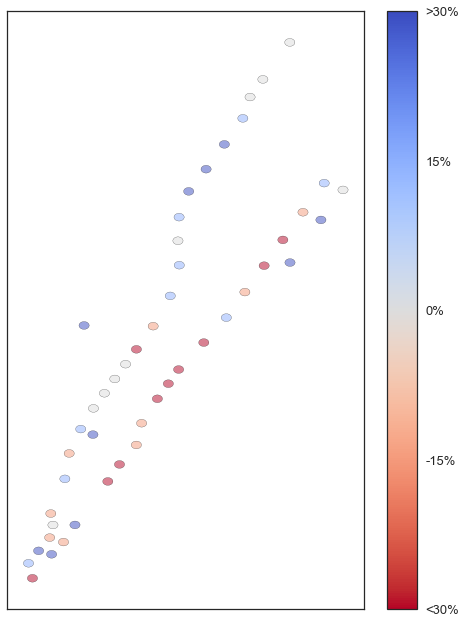

In [60]:
fig, ax = pl.subplots(figsize = (8, 11))

res_viz = gpd.GeoDataFrame(res_viz, geometry = 'buffer')

res_viz.plot('percchangemorn', cmap = cm.coolwarm_r, scheme = 'quantiles', linewidth = .2,
           ax = ax)
vmin = -.3
vmax = .3
m = cm.ScalarMappable(cmap=cm.coolwarm_r)
m.set_array(np.linspace(vmin, vmax, 200))
pl.tick_params(which = 'both',
              labelbottom = 'off',
              labelleft = 'off')

cbar = fig.colorbar(m)
cbar.set_ticks([vmin, -.15, 0, .15, vmax])
cbar.set_ticklabels(['<30%', '-15%', '0%', '15%', '>30%'])
pl.savefig('percentdiffmorn.png')

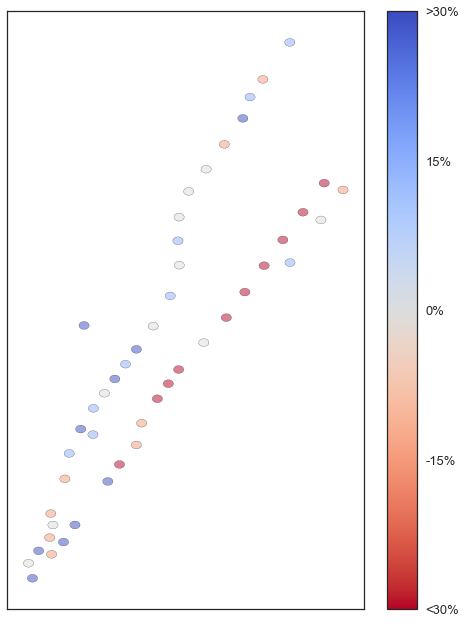

In [61]:
fig, ax = pl.subplots(figsize = (8, 11))

res_viz = gpd.GeoDataFrame(res_viz, geometry = 'buffer')

res_viz.plot('percchangeeve', cmap = cm.coolwarm_r, scheme = 'quantiles', linewidth = .2,
           ax = ax)
vmin = -.3
vmax = .3
m = cm.ScalarMappable(cmap=cm.coolwarm_r)
m.set_array(np.linspace(vmin, vmax, 200))
pl.tick_params(which = 'both',
              labelbottom = 'off',
              labelleft = 'off')

cbar = fig.colorbar(m)
cbar.set_ticks([vmin, -.15, 0, .15, vmax])
cbar.set_ticklabels(['<30%', '-15%', '0%', '15%', '>30%'])
pl.savefig('percentdiffeve.png')

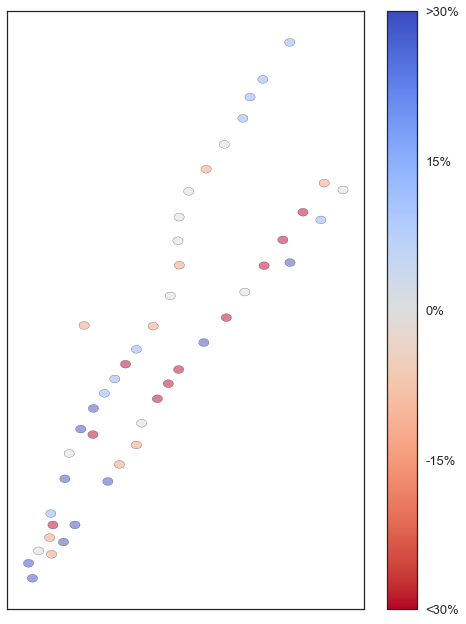

In [62]:
fig, ax = pl.subplots(figsize = (8, 11))

res_viz = gpd.GeoDataFrame(res_viz, geometry = 'buffer')

res_viz.plot('percchangeoff', cmap = cm.coolwarm_r, scheme = 'quantiles', linewidth = .2,
           ax = ax)
vmin = -.3
vmax = .3
m = cm.ScalarMappable(cmap=cm.coolwarm_r)
m.set_array(np.linspace(vmin, vmax, 200))
pl.tick_params(which = 'both',
              labelbottom = 'off',
              labelleft = 'off')

cbar = fig.colorbar(m)
cbar.set_ticks([vmin, -.15, 0, .15, vmax])
cbar.set_ticklabels(['<30%', '-15%', '0%', '15%', '>30%'])
pl.savefig('percentdiffoff.png')

In [120]:
resdf.head()

,eveavgdel,eveavgnodel,everes,evestat,mornavgdel,mornavgnodel,mornres,mornstat,offavgdel,offavgnodel,offres,offstat,station
0,34.171429,37.090909,0.093790,-1.688410,17.808511,21.479452,2.301511e-03,-3.104155,27.716667,27.966667,7.922193e-01,-0.263770,1
1,45.500000,43.946429,0.328279,0.981217,22.857143,24.366197,1.440929e-01,-1.466682,31.162162,30.584906,5.378948e-01,0.616671,3
2,1.928571,1.658537,0.299767,1.051335,1.733333,1.700000,8.576225e-01,0.180294,2.090909,1.521127,1.528646e-02,2.506255,4
7,11.590164,8.965517,0.000040,4.223359,5.458333,3.378378,1.130341e-05,4.503743,9.757009,7.178082,5.413578e-09,5.994126,29
9,57.352941,56.849315,0.893485,0.134670,46.812500,71.653846,4.679418e-08,-6.542106,57.125000,47.878205,4.151981e-03,2.990613,31


In [63]:
yellow = pd.read_csv('data/yellow_tripdata_2016-06.csv')

In [66]:
green = pd.read_csv('data/green_tripdata_2016-06.csv')

In [67]:
len(yellow) + len(green)

12540196

In [69]:
final.Taxi_Rides.sum()

1387786

In [74]:
subwaytaxi.Taxi_Rides.sum()

1307536

In [78]:
pl.histogram(subwaytaxi.Taxi_Rides)

(array([51580,  4506,   370,   274,   204,   106,    34,    16,    20,    10]),
 array([   1. ,   52.3,  103.6,  154.9,  206.2,  257.5,  308.8,  360.1,
         411.4,  462.7,  514. ]))

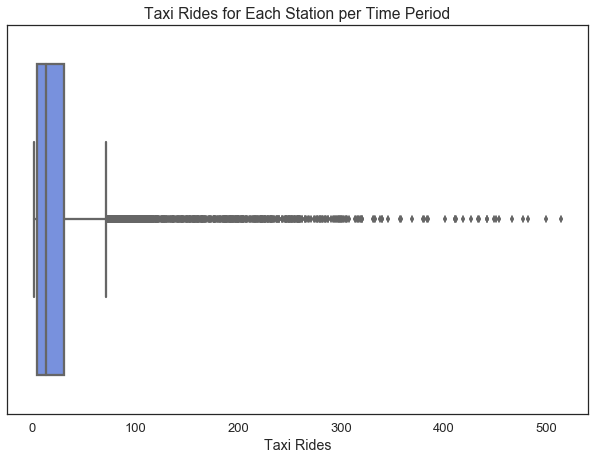

In [158]:
sns.set_context('talk')
sns.boxplot(subwaytaxi.Taxi_Rides)
pl.title('Taxi Rides for Each Station per Time Period')
pl.xlabel('Taxi Rides')
pl.savefi

In [100]:
np.arange(10, max(viz_df.Taxi_Rides), 10)

array([  10.,   20.,   30.,   40.,   50.,   60.,   70.,   80.,   90.,
        100.,  110.,  120.,  130.,  140.,  150.,  160.,  170.,  180.,
        190.,  200.,  210.])

In [102]:
max(viz_df.Taxi_Rides)

213.06205250596659

In [93]:
viz_df.Taxi_Rides

48

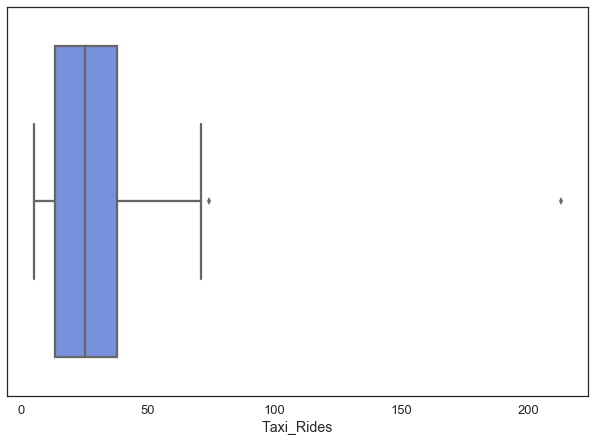

In [104]:
sns.boxplot(viz_df.Taxi_Rides)

In [128]:
len(mergedttest[mergedttest.offsign == 1])

29

In [122]:
mergedttest['mornsign_wrongway'] = [1 if (mergedttest['mornres'][x] < 0.025) & (results['mornstat'][x] < 0) else 0
                           for x in mergedttest.index]
mergedttest['evesign_wrongway'] = [1 if (mergedttest['everes'][x] < 0.025) & (results['evestat'][x] < 0) else 0
                           for x in mergedttest.index]
mergedttest['offsign_wrongway'] = [1 if (mergedttest['offres'][x] < 0.025) & (results['offstat'][x] < 0) else 0
                           for x in mergedttest.index]

In [129]:
len(mergedttest[mergedttest.offsign_wrongway == 1])

7

In [131]:
mergedttest[mergedttest.mornsign == 1][mergedttest.evesign == 1][mergedttest.offsign == 1]

/Users/shay/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,Taxi_Rides_with,Taxi_Rides_without,percchange,eveavgdel,eveavgnodel,everes,evestat,mornavgdel,mornavgnodel,mornres,...,Taxi_Rides,percchangemorn,percchangeeve,percchangeoff,mornsign,evesign,offsign,mornsign_wrongway,evesign_wrongway,offsign_wrongway
3,8.839552,6.514286,35.694881,11.590164,8.965517,0.00004,4.223359,5.458333,3.378378,0.000011,...,8.041667,0.615667,0.292749,0.359278,1,1,1,0,0,0


In [133]:
mergedttest.nameline[3]

u'Brooklyn Bridge - City Hall4-5-6-6 Express'

In [135]:
mergedttest[mergedttest.mornsign_wrongway == 1][mergedttest.evesign_wrongway == 1][mergedttest.offsign_wrongway == 1].nameline

/Users/shay/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


68                   86th St4-5-6-6 Express
45                     28th St4-6-6 Express
16                     23rd St4-6-6 Express
5                      33rd St4-6-6 Express
7                      77th St4-6-6 Express
20    68th St - Hunter College4-6-6 Express
Name: nameline, dtype: object

In [138]:
len(subwaytaxi.Hour.unique())

14

In [139]:
len(subwaytaxi.nameline.unique())

142

In [140]:
len(subwayst)

473

In [143]:
mergedttest[mergedttest.nameline == '34th St - Penn Station1-2-3']

,Taxi_Rides_with,Taxi_Rides_without,percchange,eveavgdel,eveavgnodel,everes,evestat,mornavgdel,mornavgnodel,mornres,...,Taxi_Rides,percchangemorn,percchangeeve,percchangeoff,mornsign,evesign,offsign,mornsign_wrongway,evesign_wrongway,offsign_wrongway
49,206.011494,218.069388,-5.529384,229.758621,182.934426,0.000868,3.46684,193.489362,293.60274,6.924045e-12,...,213.062053,-0.340982,0.255962,0.094785,0,1,1,1,0,0


In [161]:
len(final)

69710